<a href="https://colab.research.google.com/github/SteepDay/neural_networks/blob/main/nn_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Отображатель графиков обучения

In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K


class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()


plot = PlotLearning()



Загружаем и исследуем датасет

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(20000, 32, 32, 3) (20000, 1)


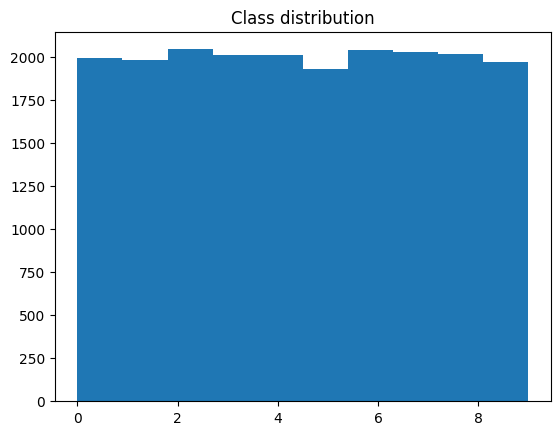

x_train shape: (20000, 32, 32, 3)
20000 train samples
10000 test samples


In [2]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import os
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

num_classes = 10

# Загрузка данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Увеличим количество данных для обучения (возьмем 20000 вместо 10000)
x_train = x_train[:20000]
y_train = y_train[:20000]
print(x_train.shape, y_train.shape)

# Визуализация распределения классов
plt.hist(y_train, bins=num_classes)
plt.title('Class distribution')
plt.show()

# Конвертация и нормализация
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Нормализация с учетом стандартного отклонения
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Вычитание среднего и деление на стандартное отклонение
mean = np.mean(x_train, axis=(0,1,2))
std = np.std(x_train, axis=(0,1,2))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Создание модели

In [3]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler

def swish(x):
    return x * K.sigmoid(x)

# Создаем более глубокую модель с регуляризацией
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))

# Слой 1
model.add(Dense(1024, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Слой 2
model.add(Dense(768, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation(swish))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Слой 3
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Слой 4
model.add(Dense(256))
model.add(Activation(swish))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Выходной слой
model.add(Dense(num_classes, activation='softmax'))

# Кастомный schedule для learning rate
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.5e-3
    elif epoch > 25:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    return lr

# Инициализация оптимизатора
opt = Adam(learning_rate=1e-3)

# Компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',
                      keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,471,818 (17.06 MB)

 Trainable params: 4,466,698 (17.04 MB)

 Non-trainable params: 5,120 (20.00 KB)

Обучение модели

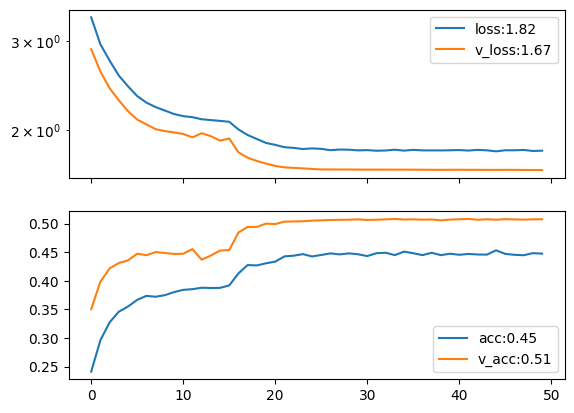

157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.4513 - loss: 1.8179 - top3_accuracy: 0.7806 - val_accuracy: 0.5077 - val_loss: 1.6691 - val_top3_accuracy: 0.8240 - learning_rate: 5.0000e-07


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 128
epochs = 50

# Улучшенная аугментация данных
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    shear_range=0.1,
    fill_mode='reflect',
    brightness_range=[0.8,1.2])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Обучение с аугментацией
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[plot, early_stop, reduce_lr, lr_scheduler],
                    verbose=1)

# Сохранение модели
model.save('improved_cifar10_model.h5')

Визуализация результатов

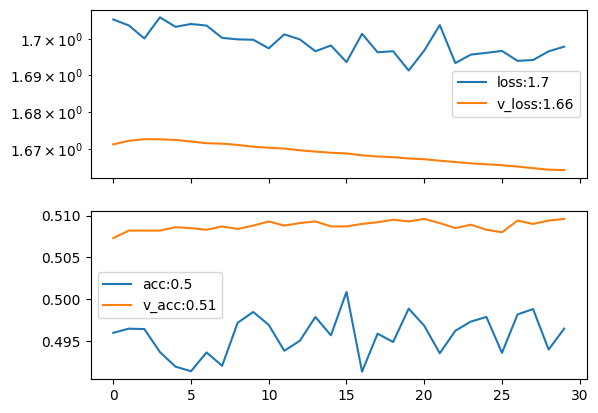

79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 438ms/step - accuracy: 0.4931 - loss: 1.6995 - top3_accuracy: 0.8167 - val_accuracy: 0.5096 - val_loss: 1.6642 - val_top3_accuracy: 0.8265


In [5]:
batch_size = 256
epochs = 30
'''
print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[plot]
          )
'''
print('Using data augmentation.')
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.,
        #brightness_range=(0.4,0.6),
        shear_range=0.1,  # set range for random shear
        zoom_range=0.1,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[plot])


Отображение результата

          GT class           Predicted class


<ipython-input-6-430ff3a6a57d>:16: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, (4., 4.))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


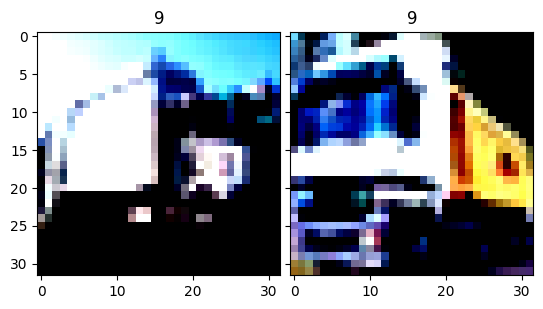

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


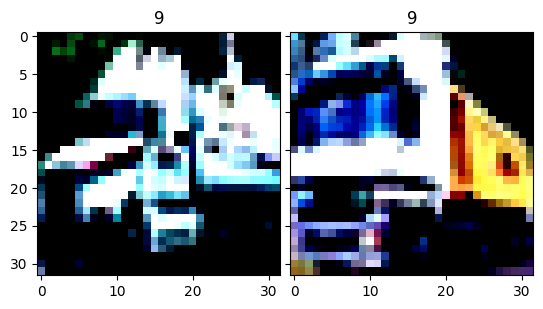

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


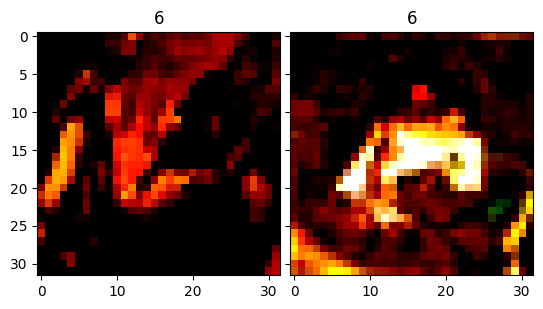

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


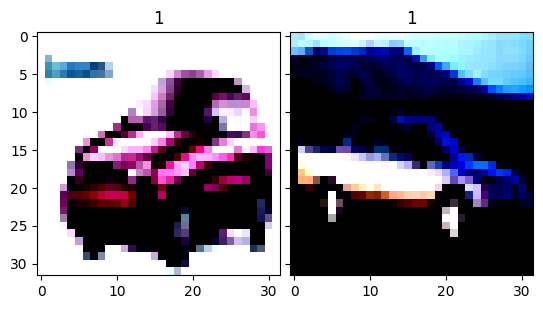

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


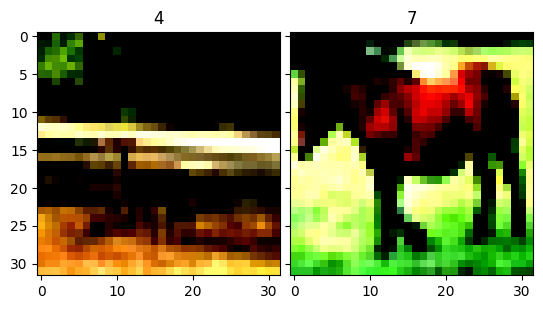

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


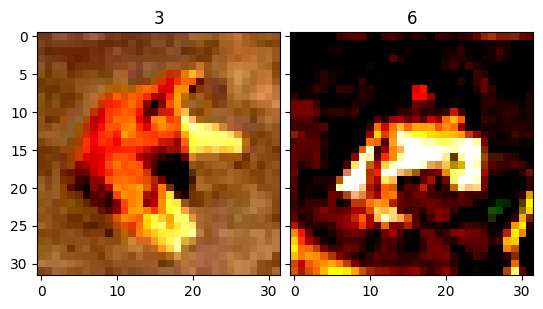

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


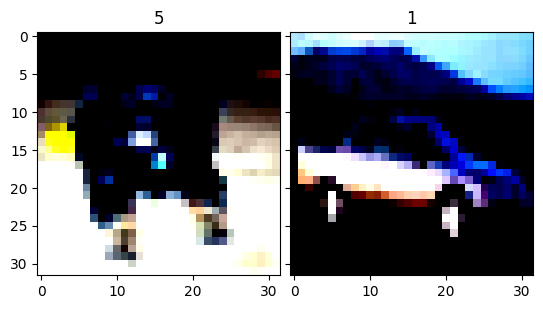

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


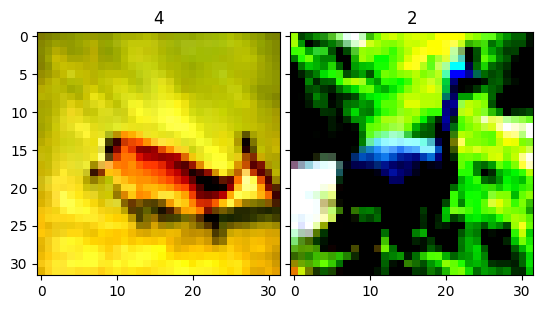

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


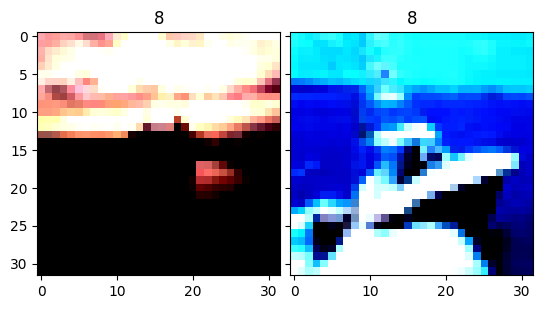

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


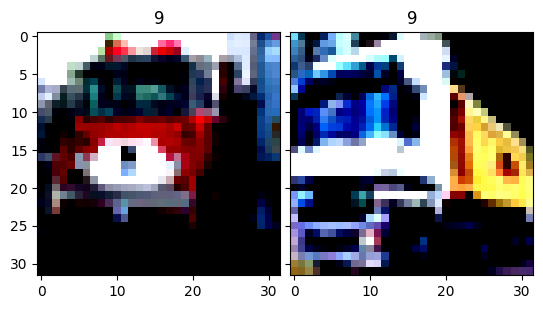

In [6]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(cls_name_pred))

    plt.show()



Отображение результатов 2

<Axes: >

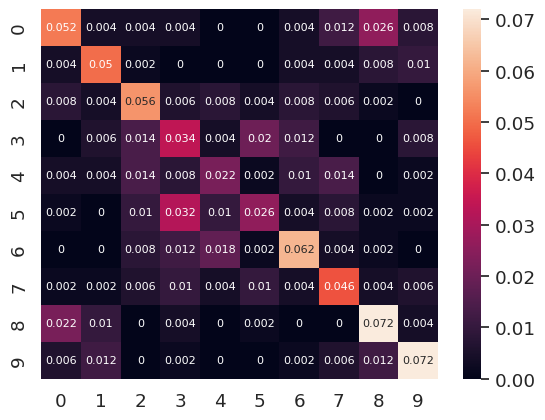

In [7]:
import pandas as pd
import seaborn as sn
from google.colab import output

def get_conf_matrix(x_test, y_test):
    p0 = []
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test:
        p = model.predict(np.expand_dims(x, axis=0))
        yp = np.argmax(p)
        ygt = np.argmax(y_test[i])
        if ygt == 0:
            p0.append(p[0][ygt])
        m[ygt,yp] += 1
        i = i+1
    m = m/len(y_test)

    return m, p0

m, p0 = get_conf_matrix(x_test[:500], y_test[:500])
output.clear()
df_cm = pd.DataFrame(m, range(10), range(10))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

Анализ обучения

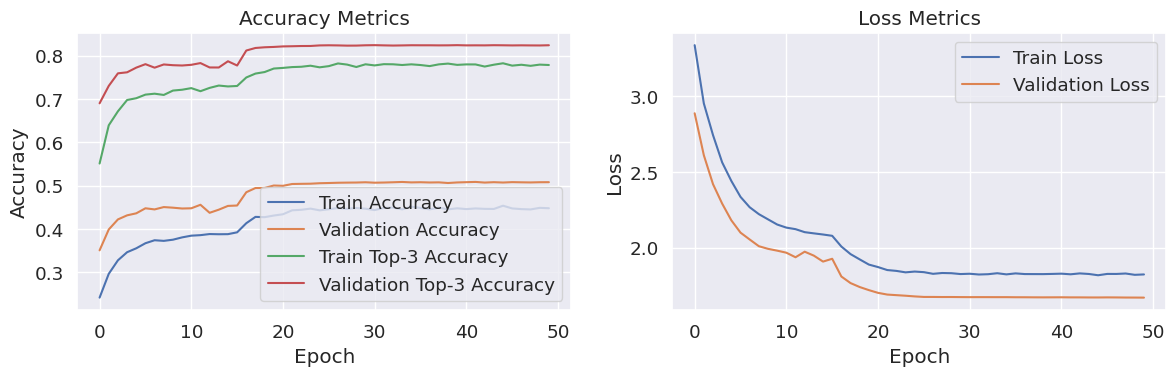


Maximum Validation Accuracy: 0.5083


In [8]:
# Анализ результатов обучения
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['top3_accuracy'], label='Train Top-3 Accuracy')
plt.plot(history.history['val_top3_accuracy'], label='Validation Top-3 Accuracy')
plt.title('Accuracy Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод максимальной точности
max_val_acc = max(history.history['val_accuracy'])
print(f"\nMaximum Validation Accuracy: {max_val_acc:.4f}")